In [1]:
#% matplotlib inline

from datetime import datetime 
import h5py
import matplotlib.pyplot as plt 
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import scipy as scp
import matplotlib.cm as cm
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
cmap = cm.get_cmap('Blues')
import random
from numpy.linalg import lstsq

import matplotlib as mpl
mpl.rcParams["image.interpolation"] = 'none'

In [2]:
# #in these fields, the shift is only 1 pixel, so they can't really be better aligned. Going to just go with them as-is
# ls_keyB = dict(
#                 experimenter = 'Vlasits',
#                 date = '20200806',
#                 exp_num = 1,
#                 field_id = 39,
#                 resample_f_id = 1,
#                 preprocess_param_set_id = 1,
#                 gp_bct_id = 3
                            
#                             )

# noise_keyB = dict(experimenter = "Vlasits",
#            date = "2020-08-06",
#            exp_num = 1, 
#            field_id = 41,
#            preprocess_param_set_id = 1,
#            spline_roi_param_id = 2,
#            spline_params_id = 1,
# )


# ls_keyA = dict(
#                 experimenter = 'Vlasits',
#                 date = '20200804',
#                 exp_num = 2,
#                 field_id = 4,
#                 resample_f_id = 1,
#                 preprocess_param_set_id = 1,
#                 gp_bct_id = 3
                            
#                             )

# noise_keyA = dict(experimenter = "Vlasits",
#            date = "2020-08-04",
#            exp_num = 2, 
#            field_id = 7,
#            preprocess_param_set_id = 1,
#            spline_roi_param_id = 2,
#            spline_params_id = 1,
# )


# ls_keyC = dict(
#                 experimenter = 'Vlasits',
#                 date = '20200806',
#                 exp_num = 1,
#                 field_id = 23,
#                 resample_f_id = 1,
#                 preprocess_param_set_id = 1,
#                 gp_bct_id = 3
                            
#                             )

# noise_keyC = dict(experimenter = "Vlasits",
#            date = "2020-08-06",
#            exp_num = 1, 
#            field_id = 25,
#            preprocess_param_set_id = 1,
#            spline_roi_param_id = 1, #WARNING THIS IS DIFFERENT
#            spline_params_id = 1,
# )

# Functions below are show as examples but will not run without the datajoint database

In [3]:
# import scipy.signal

# def cross_image(im1, im2):
#     # get rid of the averages, otherwise the results are not good
#     im1_gray = im1 - np.mean(im1)
#     im2_gray = im2 - np.mean(im2)

#     # calculate the correlation image; note the flipping of one of the images
#     return scipy.signal.fftconvolve(im1_gray, im2_gray[::-1,::-1], mode='same')

In [4]:
# def get_common_rois(ls_key, noise_key, shift):
#     # get the SD and the roi mask for this field

#     path = (Experiment() & ls_key).fetch1('headerpath')
#     path = path + 'Pre/'
#     file = (Field.RoiMask() & ls_key).fetch1('fromfile')
#     dataFile, dataCh0, osparams, trigtimesF = LoadData.loadhdf5data(path, file)

#     #calculate std
#     ls_std = np.std(dataCh0, axis=2)  # standard deviation across time
#     ls_avg_projection = np.mean(dataCh0, axis=2)

#     ls_roimask = (Field.RoiMask() & ls_key).fetch1('roi_mask')
#     ls_x_zoom = (Presentation.ScanInfo() & ls_key).fetch1('zoom')
    
#     # get the SD and the roi mask for this field

#     path = (Experiment() & noise_key).fetch1('headerpath')
#     path = path + 'Pre/'
#     file = (Field.RoiMask() & noise_key).fetch1('fromfile')
#     dataFile, dataCh0, osparams, trigtimesF = LoadData.loadhdf5data(path, file)

#     #calculate std
#     noise_std = np.std(dataCh0, axis=2)  # standard deviation across time
#     noise_avg_projection = np.mean(dataCh0, axis=2)

#     noise_roimask = (Field.RoiMask() & noise_key).fetch1('roi_mask')
#     noise_x_zoom = (Presentation.ScanInfo() & noise_key).fetch1('zoom')
    
#     if shift==1:
#         #check the image alignment
#         corr_img_ftt = cross_image(noise_avg_projection[4:,:], ls_avg_projection[4:,:])
#         corr_img_ftt_test = cross_image(noise_avg_projection[4:,:], noise_avg_projection[4:,:])
#         ind = np.unravel_index(np.argmax(corr_img_ftt, axis=None), corr_img_ftt.shape)
#         ind_test = np.unravel_index(np.argmax(corr_img_ftt_test, axis=None), corr_img_ftt_test.shape)

#         shift = np.array(ind) - np.array(ind_test)
#         x_shift = shift[1]
#         y_shift = shift[0]
    
#         corr_fixed_x = cross_image(noise_avg_projection[4-(x_shift):,-y_shift:], ls_avg_projection[4:,:]) #ls_avg_projection[4:-y_shift,:-x_shift]
#         ind_fixed_x = np.unravel_index(np.argmax(corr_fixed_x, axis=None), corr_fixed_x.shape)

#         shifty = np.array(ind_fixed_x) - np.array(ind_test)
#         x_shifty = shifty[1]
#         y_shifty = shifty[0]
        
#         corr_fixed_xy = cross_image(noise_avg_projection[4:,:], ls_avg_projection[4:-(y_shifty+y_shift),:-(x_shifty+x_shift)])
#         ind_fixed_xy = np.unravel_index(np.argmax(corr_fixed_xy, axis=None), corr_fixed_xy.shape)

#     # get the common ROIs
#     center_px_ids, pixel_lists = (NoiseSplineROIs() & noise_key).fetch('center_pixel_id', 'pixel_list')
#     threshold_count = 4
#     dsmap0 = noise_roimask*(-1)*1000
#     xlength = dsmap0.shape[0]
#     ylength = dsmap0.shape[1]
#     center_px_for_noise = [] # gives the center pixel ids that have a possible match
#     gp_pixel_lists = [] # gives a list of pixels that has a possible match

#     for i, pixel_list in enumerate(pixel_lists): #take each noise pixel list
#         x_list = []
#         y_list = []

#         for x in range(xlength):
#             for y in range(ylength):  
#                 if dsmap0[x,y]/1000 in pixel_list:
#         #             print(x,y)
#                     x_list.append(x) #make list of x and y coordinates of each pixel
#                     y_list.append(y)

#         x_list_shifted = np.array(x_list) #- (y_shift + y_shifty)

#         y_list_shifted = np.array(y_list) #- (x_shift + x_shifty)

#         count = 0
#         gp_pixel_group = []
#         for j, x in enumerate(x_list_shifted):
#             y = y_list_shifted[j]
#         #     print(ls_roimask[x, y])
#             if ls_roimask[x, y]<0:
#                 count+=1
#                 #get the pixel in gp that corresponds to the pixel in noise
#                 gp_pixel_group.append(ls_roimask[x, y]*-1) 

#         #
#         if count>threshold_count:
#             center_px_for_noise.append(center_px_ids[i]) # this is not right
#             gp_pixel_lists.append(gp_pixel_group)
    
#     center_px_ls, roi_lists_ls = (GaussianProcessBct() & ls_key).fetch('center_pixel_id', "roi_list")
#     matches = []
#     center_pixels_gp = []
#     center_pixels_noise = []

#     for i, roi_list in enumerate(roi_lists_ls):
#         if roi_list in gp_pixel_lists:
#     #         print(i)
#             matches.append(roi_list)
#             center_pixels_gp.append(center_px_ls[i])
#             noise_index = gp_pixel_lists.index(roi_list)
#             center_pixels_noise.append(center_px_for_noise[noise_index])
    
#     return center_pixels_gp, center_pixels_noise, ls_roimask, noise_roimask

In [5]:
# def get_svg_parameters_on_screen(dendrite_length, moving_bar_length, stimulus_velocity,
#                              starting_point, distance_covered, real_time_lag, time_points, space_per_pixel):
#     temporal_conversion = time_points / real_time_lag  # From seconds to pixel.
#     spatial_conversion = 1 / space_per_pixel  # From um to pixel.

#     # Moving bar is already fully on screen at t = 0
#     distance_moved = distance_covered - moving_bar_length  # [um]
#     stimulation_time = (distance_moved / stimulus_velocity)  # [s]

#     # Convert from seconds & um to pixel
#     stimulation_time_pixel = stimulation_time * temporal_conversion
# #     print(stimulation_time, stimulation_time_pixel)
#     distance_moved_pixel = distance_moved * spatial_conversion
#     dendrite_length_pixel = dendrite_length * spatial_conversion
#     moving_bar_length_pixel = moving_bar_length * spatial_conversion
#     starting_point_pixel = starting_point * spatial_conversion
#     distance_covered_pixel = distance_covered * spatial_conversion

#     # Slope of diagonal
#     slope = -stimulation_time_pixel / distance_moved_pixel

#     # Calculate thickness of diagonal
#     alpha = np.arctan(stimulation_time_pixel / distance_moved_pixel)
#     diagonal_thickness = moving_bar_length_pixel * np.sin(alpha)

#     # Calculate coordinates for beginning & end of diagonal
#     # Diagonal starts and ends out of picture to allow for a smooth & exact picture.
#     x_start = starting_point_pixel
#     x_stop = x_start + distance_covered_pixel

#     y_start = (moving_bar_length_pixel / 2) * slope  # Negative
#     y_stop = stimulation_time_pixel - y_start

# #      print(stimulation_time_pixel, dendrite_length_pixel,
# #             diagonal_thickness,
# #             x_start, x_stop, y_start, y_stop)
    
#     return (stimulation_time_pixel, dendrite_length_pixel,
#             diagonal_thickness,
#             x_start, x_stop, y_start, y_stop)

In [6]:
# def make_stimuli_convolution(noise_key):
#     distances = [120, 170, 320]
#     # responses = []
#     stimulus_images = []

#     field = noise_key
#     real_time_lag, time_points = (NoiseDesignMatrix2() & field).fetch1('real_time_lag', 'time_points')
#     space_per_pixelx, space_per_pixely = (StimulusParams.NoiseParams() & field).fetch1('box_dx_um', 'box_dy_um')
#     if space_per_pixelx < space_per_pixely:  # check which is the shorter dimension of the stimulus
#         space_per_pixel = space_per_pixelx
#     else:
#         space_per_pixel = space_per_pixely

#     for dist_cov in distances:

#         #Set up the stimuli for convolution
#         convolution_params = dict()
#         convolution_params['stimulus_velocity'] = 500 # WARNING altering this to play around with velocity tuning
#         convolution_params['dendrite_length'] = 400 #need to change this to cover the whole trajectory
#         convolution_params['distance_covered'] = dist_cov
#         convolution_params['starting_point'] = 300 - convolution_params['distance_covered']
#         convolution_params['moving_bar_length'] = 20

#         time, dend, diag, x_start, x_stop, y_start, y_stop = get_svg_parameters_on_screen(
#             convolution_params['dendrite_length'],
#             convolution_params['moving_bar_length'],
#             convolution_params['stimulus_velocity'],
#             convolution_params['starting_point'],
#             convolution_params['distance_covered'],
#             real_time_lag,
#             time_points,
#             space_per_pixel
#         )

#         string_svg = """<svg width="{0}" height="{1}" viewBox="0 0 {2} {3}">
#             <rect x="0" y="0" width="{4}" height="{5}" fill="black" />
#               <line x1="{6}" y1="{7}" x2="{8}" y2="{9}"
#                   stroke-width="{10}" stroke="white" stroke-linecap="square"/>
#             </svg>""".format(dend, time, dend, time, dend, time, x_start, y_start, x_stop, y_stop, diag)

#         folder_str = 'Data/'
#         file_name = str(1)
#         name_svg = folder_str + file_name + ".svg"
#         name_png = folder_str + file_name + ".png"
#         new_file = open(name_svg, "wt")
#         new_file.write(string_svg)
#         new_file.close()

#         cairosvg.svg2png(url=name_svg, write_to=name_png)
#         stimulus_image = np.array(Image.open(name_png).convert('L'))
#         stimulus_images.append(stimulus_image)
        
#     return stimulus_images

In [7]:
# def get_convolutions(center_pixels_noise, stim_image_index, noise_key, stimulus_images):
#     # get the predicted responses for all of the ROIs in this field for this stimulus condition
#     responses = []
#     responses_rev = []

# #     stim_image_index = 0
#     stimulus_image = stimulus_images[stim_image_index] #100 length is 0

#     for noise_px_id in center_pixels_noise:
#         noisepx = 'center_pixel_id ='+str(noise_px_id)
#         noise_spline = (NoiseSplineRF2() & noise_key & noisepx).fetch1('spl')

#         # set up and crop the kernels
#         spline = noise_spline
#         edge_buffer = 15
#         stimulus_image_rev = np.flip(stimulus_image, axis=0)
#         stimulus_images.append(stimulus_image_rev)
#         kernel_type = 'full'
#         kernel_length = stimulus_image.shape[1]  # needs to be the same length as the stimulus
#         # get the location of the RF center in the kernel
#         spline_temp = spline[edge_buffer:-edge_buffer, :]
#         # crop the kernel depending on the type of experiment
#         if kernel_type == 'full':
#             spline_cut = spline[edge_buffer:-edge_buffer,
#                          0:kernel_length]  # should be full kernel, just adding space range just in case
#         else:
#             spline_cut = spline  # just to make the code happy, this should never be the option
#         # check whether cut spline is big enough
#         space_length = spline_cut.shape[1]


#         #convolve!
#         if kernel_length == space_length:
#             empty_flag = 0
#             # setup output variables
#             convolved_response = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))
#             convolved_response_rev = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))
#             # loop through x positions and convolve
#             for x_position in range(stimulus_image.shape[1]):
#                 ker = np.flip(spline_cut[:, x_position])
#                 img = stimulus_image[:, x_position]
#                 img2 = stimulus_image_rev[:, x_position]
#                 # and then convolve these two
#                 convolved_response[:, x_position] = np.convolve(a=img, v=ker, mode='full')
#                 convolved_response_rev[:, x_position] = np.convolve(a=img2, v=ker, mode='full')
#         else:
#             empty_flag = 1
#             convolved_response = []
#             convolved_response_rev = []
#         response = np.sum(convolved_response, axis=1)
#         response_rev = np.sum(convolved_response_rev, axis=1)
#         responses.append(response)
#         responses_rev.append(response_rev)
        
#     return responses, responses_rev    

In [8]:
# def do_correlations(responses, responses_rev, ls_key, center_pixels_gp, index1, index2):
#     # get the corresponding GP response

#     time_cut = 1.1 # aligning the beginning of the convolutions and GP predictions
#     dilation = 1.15 # adjusting the time scale manually to get better fits.  

#     #these match the 100 out conditions
#     gp_index = [3, 0, 5, 2, 4, 1]
# #     index1 = 0
# #     index2 = 1

#     corrs = []
#     corrs_rev = []
#     gp_interp = []
#     gp_interp_rev = []
#     responses_scaled = []
#     responses_scaled_rev = []

#     for i, response in enumerate(responses):
#         response_rev = responses_rev[i]

#         gppx = 'center_pixel_id ='+str(center_pixels_gp[i])
#         gp_result = (GaussianProcessBct() & ls_key & gppx).fetch1()
#         mu = gp_result['mu']
#         x_predict = gp_result['x_predict']
#         sig = gp_result['sig']
#         sig_outer = gp_result['sig_outer']
#         x_predict_t = np.copy(x_predict[::mu.shape[0],:])

#         norm_factor = response.max()#np.array([response.max() for response in responses]).max()
#         scale_factor = (mu[gp_index[index1],:][np.where(x_predict_t[:,0]>time_cut)]).max() #/sd_of_trace

#         #Calculate correlation outward
#         gp_x = x_predict_t[:,0][np.where(x_predict_t[:,0]>time_cut)]
#         gp_y = mu[gp_index[index1],:][np.where(x_predict_t[:,0]>time_cut)]#/sd_of_trace
#         x_scale_pred = np.linspace(time_cut, 1+(response.shape[0]*2*dilation)/1000, (response.shape[0]))
#         y_vals_pred = response*scale_factor/norm_factor
#         start = x_scale_pred.min()
#         stop = x_scale_pred.max()
#         x = np.linspace(start, stop, num=response.shape[0]) 
#         interp_gp = np.interp(x, gp_x, gp_y)
#         gp_noise_corr = scipy.stats.pearsonr(list(interp_gp), list(y_vals_pred))
#         corrs.append(gp_noise_corr)
#         gp_interp.append(interp_gp)
#         responses_scaled.append(y_vals_pred)

#         #Calculate correlation inward
#         gp_y = mu[gp_index[index2],:][np.where(x_predict_t[:,0]>time_cut)]#/sd_of_trace
#         y_vals_pred = response_rev*scale_factor/norm_factor
#         interp_gp = np.interp(x, gp_x, gp_y)
#         gp_noise_corr = scipy.stats.pearsonr(list(interp_gp), list(y_vals_pred))
#         corrs_rev.append(gp_noise_corr)
#         gp_interp_rev.append(interp_gp)
#         responses_scaled_rev.append(y_vals_pred)
#     return corrs, corrs_rev, gp_interp, gp_interp_rev, responses_scaled, responses_scaled_rev

In [9]:
# def organize_correlations(corrs, corrs_rev, ls_key, center_pixels_gp, ls_roimask, center_shift):
#     pearson_r_vals = np.array([corr[0] for corr in corrs])
#     pearson_r_vals_rev = np.array([corrs_rev[0] for corrs_rev in corrs_rev])
#     p_values = np.array([corrs_rev[1] for corrs_rev in corrs_rev])
#     p_values_rev = np.array([corr[1] for corr in corrs])
#     significant = np.where(p_values<0.05)[0]
#     pixels_gp = np.array(center_pixels_gp)
    
#     x_positions_gp = np.zeros(pixels_gp.shape)

#     for i in range(pixels_gp.shape[0]):
#         x_positions_gp[i] = np.where(ls_roimask == -1*pixels_gp[i])[0][0]

#     zoom = (Presentation.ScanInfo() & ls_key).fetch1('zoom')
#     um_pixel = (71.5/zoom)/128

#     x_positions_gp_um = x_positions_gp*um_pixel
#     x_positions_gp_um_centered = x_positions_gp_um-center_shift
    
#     return pearson_r_vals, pearson_r_vals_rev, p_values, p_values_rev, x_positions_gp_um_centered

In [10]:
# center_pixels_gpA, center_pixels_noiseA, ls_roimaskA, noise_roimaskA = get_common_rois(ls_keyA, noise_keyA, 1)
# center_pixels_gpB, center_pixels_noiseB, ls_roimaskB, noise_roimaskB = get_common_rois(ls_keyB, noise_keyB, 0)
# center_pixels_gpC, center_pixels_noiseC, ls_roimaskC, noise_roimaskC = get_common_rois(ls_keyC, noise_keyC, 0)

In [11]:
# stimulus_imagesA = make_stimuli_convolution(noise_keyA)
# stimulus_imagesB = make_stimuli_convolution(noise_keyB)
# stimulus_imagesC = make_stimuli_convolution(noise_keyC)

In [12]:
# stim_image_indexA = 2
# responsesA, responses_revA = get_convolutions(center_pixels_noiseA, stim_image_indexA, noise_keyA, stimulus_imagesA)

# stim_image_indexB = 2
# responsesB, responses_revB = get_convolutions(center_pixels_noiseB, stim_image_indexB, noise_keyB, stimulus_imagesB)

# stim_image_indexC = 2
# responsesC, responses_revC = get_convolutions(center_pixels_noiseC, stim_image_indexC, noise_keyC, stimulus_imagesC)

In [13]:
# index1A = 4
# index2A = 5
# corrsA, corrs_revA, gp_interpA, gp_interp_revA, responses_scaledA, responses_scaled_revA = do_correlations(
#     responsesA, responses_revA, ls_keyA, center_pixels_gpA, index1A, index2A)

# index1B = 4
# index2B = 5
# corrsB, corrs_revB, gp_interpB, gp_interp_revB, responses_scaledB, responses_scaled_revB = do_correlations(
#     responsesB, responses_revB, ls_keyB, center_pixels_gpB, index1B, index2B)

# index1C = 4
# index2C = 5
# corrsC, corrs_revC, gp_interpC, gp_interp_revC, responses_scaledC, responses_scaled_revC = do_correlations(
#     responsesC, responses_revC, ls_keyC, center_pixels_gpC, index1C, index2C)

In [14]:
# center_shiftA = 30
# pearson_r_valsA, pearson_r_vals_revA, p_valuesA, p_values_revA, x_positions_gp_um_centeredA = organize_correlations(
#     corrsA, corrs_revA, ls_keyA, center_pixels_gpA, ls_roimaskA, center_shiftA)

# center_shiftB = 85
# pearson_r_valsB, pearson_r_vals_revB, p_valuesB, p_values_revB, x_positions_gp_um_centeredB = organize_correlations(
#     corrsB, corrs_revB, ls_keyB, center_pixels_gpB, ls_roimaskB, center_shiftB)

# center_shiftC = 40
# pearson_r_valsC, pearson_r_vals_revC, p_valuesC, p_values_revC, x_positions_gp_um_centeredC = organize_correlations(
#     corrsC, corrs_revC, ls_keyC, center_pixels_gpC, ls_roimaskC, center_shiftC)

In [15]:
# stimulatedA = np.where(x_positions_gp_um_centeredA>-200)[0]
# stimulatedB = np.where(x_positions_gp_um_centeredB>-200)[0]
# stimulatedC = np.where(x_positions_gp_um_centeredC>-200)[0]

In [16]:
# pearson_r_valsALL = np.concatenate((
#     pearson_r_valsA[stimulatedA],
#     pearson_r_valsB[stimulatedB],
#     pearson_r_valsC[stimulatedC]))

# pearson_r_vals_revALL = np.concatenate((
#     pearson_r_vals_revA[stimulatedA],
#     pearson_r_vals_revB[stimulatedB],
#     pearson_r_vals_revC[stimulatedC]))

# This part runs from hdf5 file

In [17]:
#read hdf5 file for this notebook
f1 = h5py.File("Data/FigS04_gh.hdf5", "r")

#get the data for plotting the sd image
pearson_r_valsALL_300 = np.array(f1['pearson_r_valsALL_300'])
pearson_r_vals_revALL_300 = np.array(f1['pearson_r_vals_revALL_300'])
pearson_r_valsALL_100 = np.array(f1['pearson_r_valsALL_100'])
pearson_r_vals_revALL_100 = np.array(f1['pearson_r_vals_revALL_100'])

f1.close()

0.6445356807965558


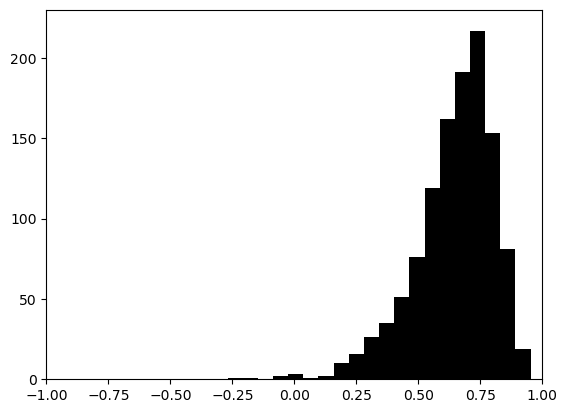

In [18]:
plt.hist(pearson_r_valsALL_300, bins=20, color='k')

print(pearson_r_valsALL_300.mean())

axes=plt.gca()
axes.set_xlim([-1,1])
axes.set_ylim([0,230])

# Figpath = 'Fig_temp/'
# savename = Figpath+"Correlation_histogram_300.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

plt.show()

0.45041824067791


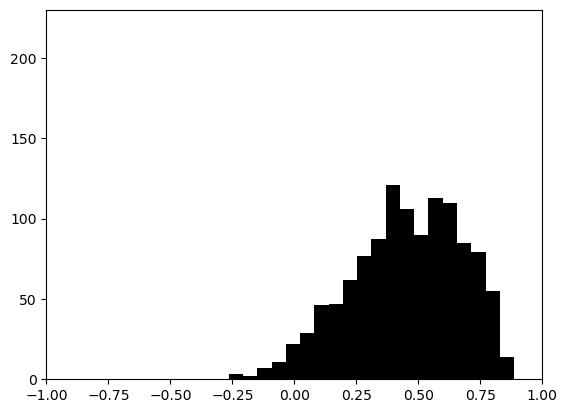

In [19]:

plt.hist(pearson_r_vals_revALL_300, bins=20, color='k')

print(pearson_r_vals_revALL_300.mean())
axes=plt.gca()
axes.set_xlim([-1,1])
axes.set_ylim([0,230])

# Figpath = 'Fig_temp/'
# savename = Figpath+"Correlation_histogram_300_rev.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

plt.show()

0.5377066434811781


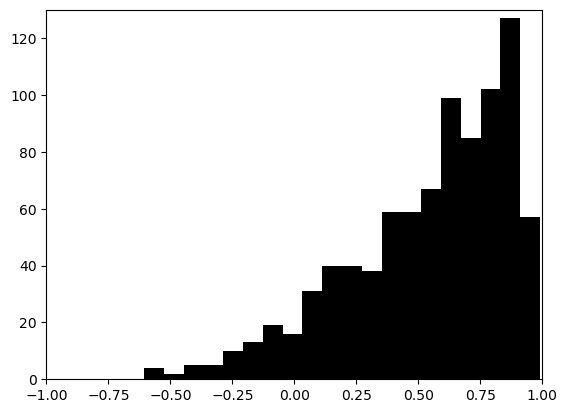

In [20]:
plt.hist(pearson_r_valsALL_100, bins=20, color='k')

print(pearson_r_valsALL_100.mean())
axes=plt.gca()
axes.set_xlim([-1,1])
axes.set_ylim([0,130])

# Figpath = 'Fig_temp/'
# savename = Figpath+"Correlation_histogram_100.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

plt.show()

0.39568309702785


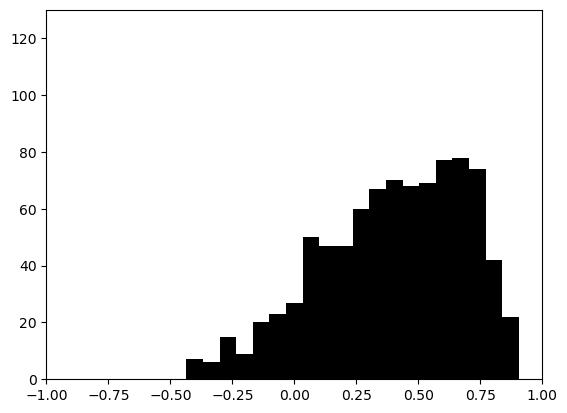

In [21]:
plt.hist(pearson_r_vals_revALL_100, bins=20, color='k')

print(pearson_r_vals_revALL_100.mean())
axes=plt.gca()
axes.set_xlim([-1,1])
axes.set_ylim([0,130])

# Figpath = 'Fig_temp/'
# savename = Figpath+"Correlation_histogram_100_rev.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

plt.show()

In [22]:
# plt.hist(pearson_r_valsA[stimulatedA])
# print(pearson_r_valsA[stimulatedA].mean())
# plt.show()

In [23]:
# plt.hist(pearson_r_valsB[stimulatedB])
# print(pearson_r_valsB[stimulatedB].mean())
# plt.show()

In [24]:
# plt.hist(pearson_r_valsC[stimulatedC])
# print(pearson_r_valsC[stimulatedC].mean())
# plt.show()

# shuffling

#concatenate all of the responses and the center pixels and ls keys, then do bootstrap. Bootstrap results are included as numpy files so figures can be recreated.

In [25]:
# #concatenate all the responses
# responses_scaled_ALL = responses_scaledA + responses_scaledB + responses_scaledC
# gp_interpALL = gp_interpA + gp_interpB + gp_interpC
# stimulatedALL = np.where(np.concatenate((x_positions_gp_um_centeredA, x_positions_gp_um_centeredB, x_positions_gp_um_centeredC))>0)

# #only shuffle the stimulated areas
# responses_scaled_ALL_stimulated = np.array(responses_scaled_ALL)[stimulatedALL]
# gp_interpALL_stimulated = np.array(gp_interpALL)[stimulatedALL]
# gp_interpALL_stimulated_shuffled = np.copy(gp_interpALL_stimulated)

# iterations = 1000
# bootstrap_distribution = np.zeros(iterations)

# for i in range(iterations):
    
#     np.random.shuffle(gp_interpALL_stimulated_shuffled)
#     corrs_shuffled = np.zeros(responses_scaled_ALL_stimulated.shape[0])
#     for j, response in enumerate(responses_scaled_ALL_stimulated):
#         interp_gp = gp_interpALL_stimulated_shuffled[j]

#         gp_noise_corr = scipy.stats.pearsonr(list(interp_gp), list(response))
#         corrs_shuffled[j] = gp_noise_corr[0]
    
#     bootstrap_distribution[i] = np.mean(corrs_shuffled)

In [26]:
bootstrap_distribution_300 = np.load('Data/bootstrap_distribution_300_out.npy')

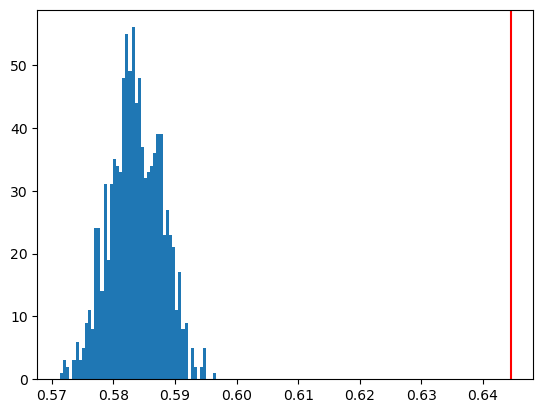

In [27]:
plt.hist(bootstrap_distribution_300, bins=50)
axes = plt.gca()
axes.axvline(pearson_r_valsALL_300.mean(), color='r')

axes = plt.gca()
# axes.set_xlim([0.35, 0.55])
plt.show()

In [28]:
np.quantile(bootstrap_distribution_300, [0.05, 0.95])

array([0.57688013, 0.59048263])

In [29]:
# np.save('bootstrap_distribution_300_out.npy', bootstrap_distribution)

In [30]:
bootstrap_distribution_rev_300 = np.load('Data/bootstrap_distribution_300_in.npy')

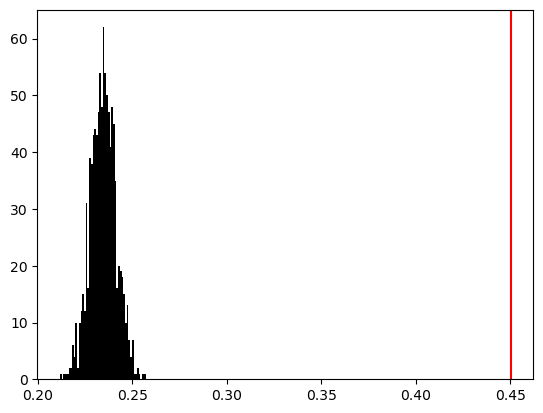

In [31]:
plt.hist(bootstrap_distribution_rev_300, bins=50, color = 'k')

axes = plt.gca()
# axes.set_xlim([0.35, 0.60])

axes.axvline(pearson_r_vals_revALL_300.mean(), color='r')

# Figpath = 'Fig_temp/'
# savename = Figpath+"Shuffled_mean_distribution_100.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')


plt.show()

In [32]:
# np.save('bootstrap_distribution_300_in.npy', bootstrap_distribution_rev)

In [33]:
bootstrap_distribution_100 = np.load('Data/bootstrap_distribution_100_out.npy')

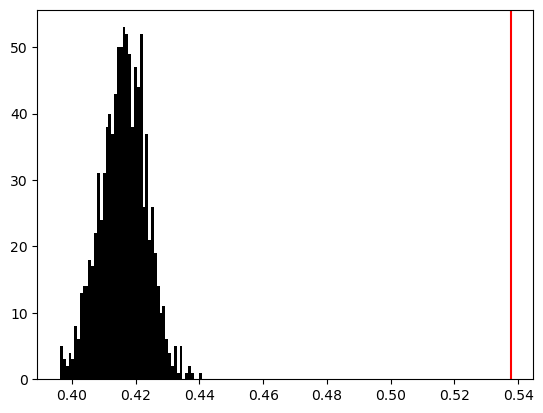

In [34]:
plt.hist(bootstrap_distribution_100, bins=50, color = 'k')

axes = plt.gca()
# axes.set_xlim([0.35, 0.60])

axes.axvline(pearson_r_valsALL_100.mean(), color='r')

# Figpath = 'Fig_temp/'
# savename = Figpath+"Shuffled_mean_distribution_100.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')
# this is the distribution shown in the paper

plt.show()

In [35]:
bootstrap_distribution_rev_100 = np.load('Data/bootstrap_distribution_100_in.npy')

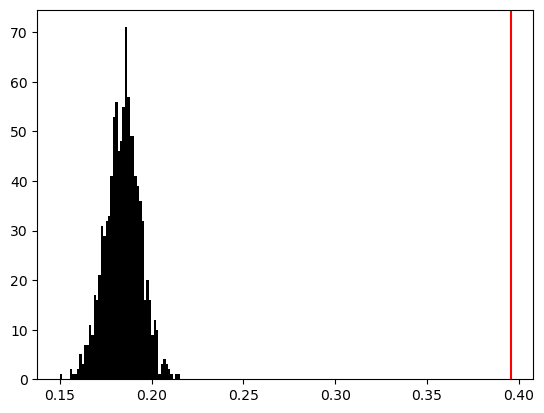

In [36]:
plt.hist(bootstrap_distribution_rev_100, bins=50, color = 'k')

axes = plt.gca()
# axes.set_xlim([0.35, 0.60])

axes.axvline(pearson_r_vals_revALL_100.mean(), color='r')

# Figpath = 'Fig_temp/'
# savename = Figpath+"Shuffled_mean_distribution_100.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')


plt.show()